# Testing CNN Shape Measurement Responsivity of Simple Galaxy Models

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.stats import gaussian_kde, pearsonr

#tensorflow
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
print("Tensorflow version: {}".format(tf.version.VERSION))

#keras only after gpu ID and memory usage is set
import tensorflow.keras.models as km
import tensorflow.keras.layers as kl
import tensorflow.keras.regularizers as kr
import tensorflow.keras.optimizers as ko

import tensorflow_datasets as tfds
import autometacal as amc
import galsim
import tqdm

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Tensorflow version: 2.7.0


## CNN Models

In [3]:
def Ribli19(imsize=50, n_target=2 ,n_channels=1, nf=64, reg = 5e-5,
          padding='same'):

    #input
    inp = kl.Input((imsize, imsize,n_channels))
    
    # conv block 1
    x = kl.Conv2D(nf, (3, 3), padding=padding,kernel_regularizer=kr.l2(reg))(inp)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(nf, (3, 3), padding=padding,kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.MaxPooling2D(strides=(2,2))(x)
    
    # conv block 2
    x = kl.Conv2D(2*nf, (3, 3), padding=padding,kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(2*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.MaxPooling2D(strides=(2,2))(x)

    # conv block 3
    x = kl.Conv2D(4*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(2*nf, (1, 1), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(4*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    x = kl.MaxPooling2D(strides=(2,2))(x)

    # conv block 4
    x = kl.Conv2D(8*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(4*nf, (1, 1), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(8*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    x = kl.MaxPooling2D(strides=(2,2))(x)
    
    # conv block 5
    x = kl.Conv2D(16*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(8*nf, (1, 1), padding=padding,  kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(16*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    #  end of conv
    
    x = kl.GlobalAveragePooling2D()(x)    
    x = kl.Dense(n_target)(x)#, name = 'final_dense_n%d_ngpu%d' % (n_target, len(gpu.split(','))))(x)  

    model = km.Model(inputs=inp, outputs=x)  # make model
       
    return model


## Load Data

In [4]:
from autometacal.python.datasets import GalGen

In [5]:
batch_size=64
data= tfds.load('GalGen/small_stamp_100k')
data = data['train'].cache()
data = data.repeat()
data = data.shuffle(1000)
data = data.batch(batch_size)
data = data.prefetch(tf.data.experimental.AUTOTUNE)

In [6]:
batchit = data.as_numpy_iterator()
onebatch = batchit.next()

reconv_psf = galsim.Moffat(beta=2.5, fwhm=0.9*1.2)

reconv_psf_image = tf.expand_dims(tf.convert_to_tensor(reconv_psf.drawImage(nx=51, ny=51, scale=.2).array),axis=0)
gal_images,psf_images = onebatch['obs_image'],onebatch['psf_image'] 

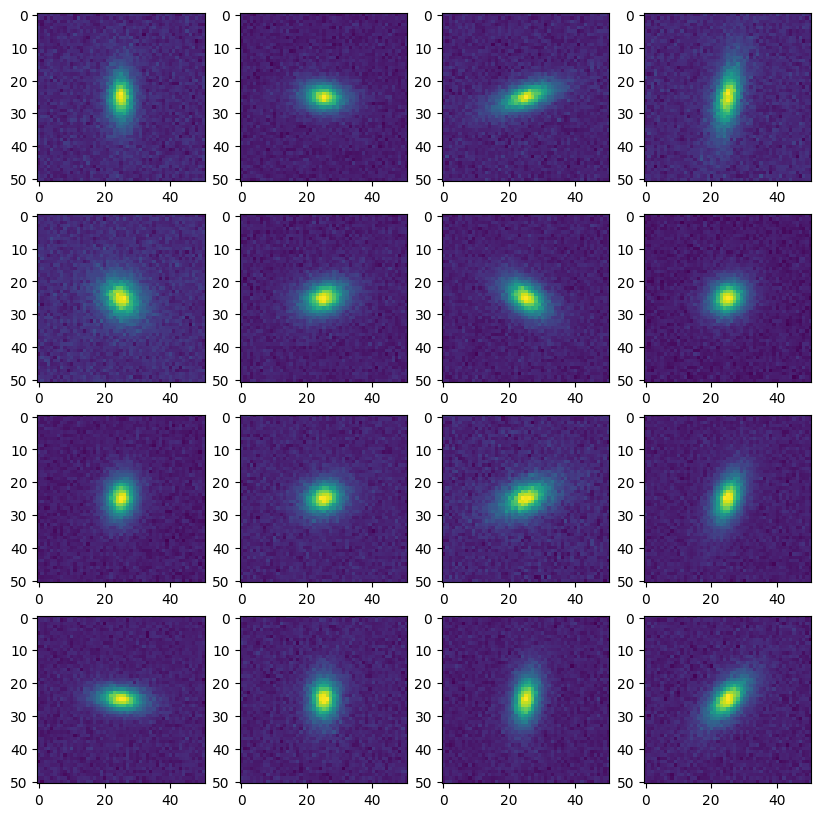

In [7]:
plt.style.use('default')
plt.figure(figsize=(10,10))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(gal_images[i])

### Test with finitediff

In [8]:
@tf.function
def get_metacal_response_finitediff(gal_image,
                                    psf_image,
                                    reconv_psf_image,
                                    shear,
                                    step,
                                    method):
  """
  Gets shear response as a finite difference operation, 
  instead of automatic differentiation.
  """
  batch_size, _ , _ = gal_image.get_shape().as_list()
  step_batch = tf.constant(step,shape=(batch_size,1),dtype=tf.float32)
  
  step1p = tf.pad(step_batch,[[0,0],[0,1]])
  step1m = tf.pad(-step_batch,[[0,0],[0,1]])
  step2p = tf.pad(step_batch,[[0,0],[1,0]])
  step2m = tf.pad(-step_batch,[[0,0],[1,0]])
    
  img0s = generate_mcal_image(
    gal_image,
    psf_image,
    reconv_psf_image,
    tf.zeros([batch_size,2])
  ) 
  
  shears1p = shear + step1p
  img1p = generate_mcal_image(
    gal_image,
    psf_image,
    reconv_psf_image,
    shears1p
  )
  
  shears1m = shear + step1m 
  img1m = generate_mcal_image(
    gal_image,
    psf_image,
    reconv_psf_image,
    shears1m
  ) 
  
  shears2p = shear + step2p 
  img2p = generate_mcal_image(
    gal_image,
    psf_image,
    reconv_psf_image,
    shears2p
  )
  
  shears2m = shear + step2m 
  img2m = generate_mcal_image(
    gal_image,
    psf_image,
    reconv_psf_image,
    shears2m
  ) 
  
  g0s = method(img0s)
  g1p = method(img1p)
  g1m = method(img1m)
  g2p = method(img2p)
  g2m = method(img2m)
  
  R11 = (g1p[:,0]-g1m[:,0])/(2*step)
  R21 = (g1p[:,1]-g1m[:,1])/(2*step) 
  R12 = (g2p[:,0]-g2m[:,0])/(2*step)
  R22 = (g2p[:,1]-g2m[:,1])/(2*step)
 
  #N. B.:The matrix is correct. 
  #The transposition will swap R12 with R21 across a batch correctly.
  R = tf.transpose(tf.convert_to_tensor(
    [[R11,R21],
     [R12,R22]],dtype=tf.float32)
  )
  
  ellip_dict = {
    'noshear':g0s,
    '1p':g1p,
    '1m':g1m,
    '2p':g2p,
    '2m':g2m,    
  } 
  
  return ellip_dict, R

In [9]:
generate_mcal_image = amc.generate_mcal_image

In [10]:
def lossad(batch,model):
  
  shears = tf.random.uniform((batch_size,2),-.1,.1,dtype=tf.float32)

  R = amc.get_metacal_response(batch['obs_image'],batch['psf_image'],shears,reconv_psf_image,model)[1]
  
  lost = tf.norm(R - tf.eye(2))
  
  return lost

In [11]:
@tf.function
def loss(batch,model):
  obs_image, psf_image = batch
  shears = tf.random.uniform((batch_size,2),-.1,.1,dtype=tf.float32)
  #compute response
  R = get_metacal_response_finitediff(obs_image,
                                      psf_image,
                                      reconv_psf_image,
                                      shear=shears,
                                      step=0.01,
                                      method=model)[1]
 
  lost = tf.reduce_sum((R-tf.eye(2))**2,axis=-1)
  lost = tf.reduce_sum(lost, axis=-1)
  lost = tf.reduce_mean(lost)

  
  return lost

In [12]:
@tf.function
def step(batch):
  
  with tf.GradientTape() as tape:
    tape.watch(model.trainable_variables)
       
    lost = loss(batch,model)
    

  grads = tape.gradient(lost, model.trainable_variables)
  opt.apply_gradients(zip(grads, model.trainable_variables))
  return lost
   
opt = ko.Adam()  

In [13]:
model = Ribli19(51,n_channels=1)

In [14]:
batchteste = onebatch['obs_image'], onebatch['psf_image']
step(batchteste)

<tf.Tensor: shape=(), dtype=float32, numpy=2.0010693>

In [15]:
lost = []
its = []
iterations = 1000
for it in range(iterations):
  batch = batchit.next()
  batch = batch['obs_image'], batch['psf_image'] 
  nowlost = step(batch)
  if not it%10:
    print(f"{nowlost: .4f},   {it}  ",end='\r')
    lost.append(nowlost)
    its.append(it)  
model.save("RLmodel.model")

INFO:tensorflow:Assets written to: RLmodel.model/assets


INFO:tensorflow:Assets written to: RLmodel.model/assets


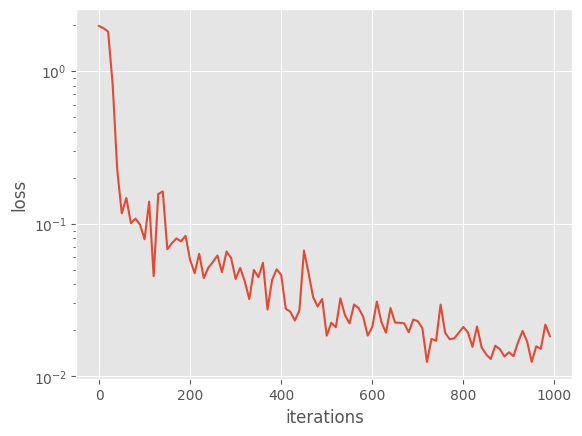

In [16]:
style.use('ggplot')
plot(its,lost)
xlabel('iterations')
ylabel('loss')
yscale('log')
savefig(f'learningRloss{time.time()}.png',bbox_inches='tight')

In [17]:
garray_list = []
e_auto_list = []
R_auto_list = []
for n in tqdm.tqdm(range(10)):
  batch = batchit.next()
  garray=batch['label']
  garray_list.append(garray)
  e_auto, R_auto = amc.get_metacal_response(batch['obs_image'],batch['psf_image'],reconv_psf_image,model)
  e_auto_list.append(e_auto)
  R_auto_list.append(R_auto)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:36,  4.06s/it]

 20%|██        | 2/10 [00:07<00:29,  3.72s/it]

 30%|███       | 3/10 [00:11<00:25,  3.62s/it]

 40%|████      | 4/10 [00:14<00:21,  3.57s/it]

 50%|█████     | 5/10 [00:18<00:18,  3.61s/it]

 60%|██████    | 6/10 [00:21<00:14,  3.57s/it]

 70%|███████   | 7/10 [00:25<00:10,  3.54s/it]

 80%|████████  | 8/10 [00:28<00:07,  3.53s/it]

 90%|█████████ | 9/10 [00:32<00:03,  3.57s/it]

100%|██████████| 10/10 [00:35<00:00,  3.58s/it]


In [18]:
garray=tf.concat(garray_list,axis=0)
e_auto=tf.concat(e_auto_list,axis=0)
R_auto=tf.concat(R_auto_list,axis=0)

In [19]:
np.save("garray.npy",garray.numpy())
np.save("e_auto.npy",e_auto.numpy())
np.save("R_auto.npy",R_auto.numpy())

In [20]:
calibre_f=mean(tf.linalg.inv(R_auto[:]),axis=0) @ tf.reshape(e_auto,[-1,2,1])

In [21]:
mean(tf.linalg.inv(R_auto[:]),axis=0)

array([[ 1.0458925 , -0.0081312 ],
       [-0.02574497,  1.034853  ]], dtype=float32)

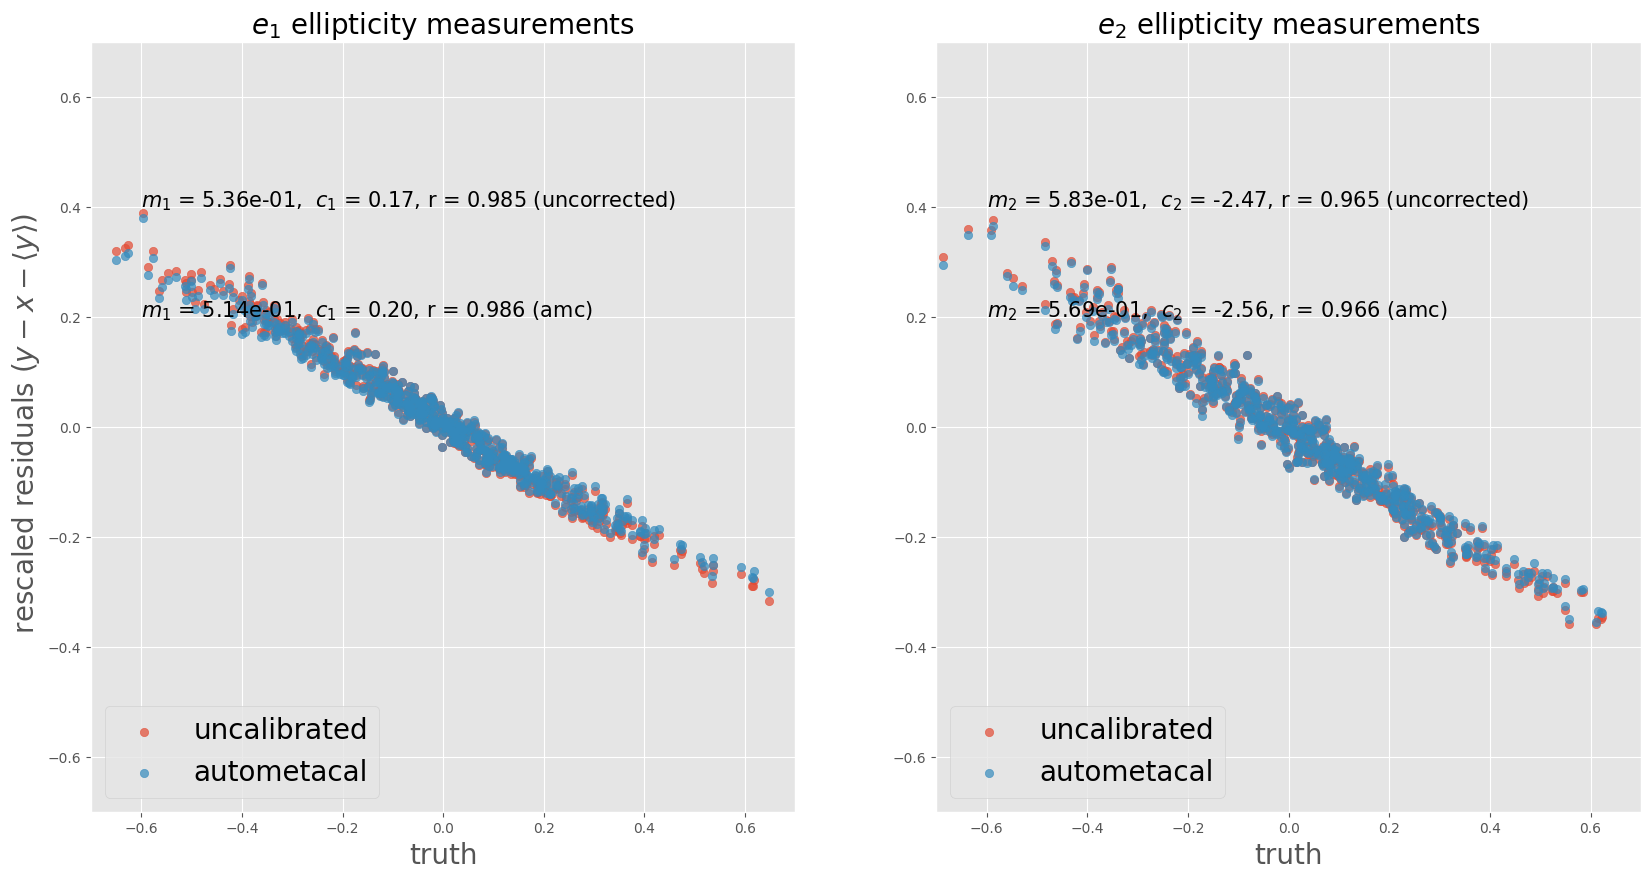

In [22]:
figure(figsize=(20,10))
style.use('ggplot')
subplot(121)

x1 = garray[:,0]
x2 = garray[:,1]

y1 = e_auto[:,0]
y1corr = calibre_f[:,0,0]

y2 = e_auto[:,1]
y2corr = calibre_f[:,1,0]

#linear fit
poly_g1 = np.polyfit(x1,y1,1)
poly_g2 = np.polyfit(x2,y2,1)


poly_g1corr = np.polyfit(x1,y1corr,1)
poly_g2corr = np.polyfit(x2,y2corr,1)


#correlation coefficient
corr_g1 = pearsonr(x1,y1)
corr_g2 = pearsonr(x2,y2)


corr_g1corr = pearsonr(x1,y1corr)
corr_g2corr = pearsonr(x2,y2corr)


scatter(x1,y1-x1-mean(y1),alpha=.7,label="uncalibrated")
scatter(x1,y1corr-x1-mean(y1corr),alpha=.7,label="autometacal")
text(-.6,0.4, "$m_1$ = {:.2e},  $c_1$ = {:.2f}, r = {:.3f} (uncorrected)".format(1-poly_g1[0],poly_g1[1],corr_g1[0]),fontsize=15)
text(-.6,0.2, "$m_1$ = {:.2e},  $c_1$ = {:.2f}, r = {:.3f} (amc)".format(1-poly_g1corr[0],poly_g1corr[1],corr_g1corr[0]),fontsize=15)



title("$e_1$ ellipticity measurements", fontsize=20)
xlabel("truth",fontsize=20)
ylabel(" rescaled residuals ($y-x-\\langle y \\rangle $)",fontsize=20)
legend(fontsize=20,loc=3)
xlim(-0.7,0.7)
ylim(-0.7,0.7)

subplot(122)

scatter(x2,y2-x2-mean(y2),alpha=.7,label="uncalibrated")
scatter(x2,y2corr-x2-mean(y2corr),alpha=.7,label="autometacal")
text(-.6,0.4 , "$m_2$ = {:.2e},  $c_2$ = {:.2f}, r = {:.3f} (uncorrected) ".format(1-poly_g2[0],poly_g2[1],corr_g2[0]),fontsize=15)
text(-.6,0.2 , "$m_2$ = {:.2e},  $c_2$ = {:.2f}, r = {:.3f} (amc)".format(1-poly_g2corr[0],poly_g2corr[1],corr_g2corr[0]),fontsize=15)

title("$e_2$ ellipticity measurements", fontsize=20)
xlabel("truth",fontsize=20)

legend(fontsize=20,loc=3)
xlim(-0.7,0.7)
ylim(-0.7,0.7)
savefig(f"linearity{time.time()}.pdf",bbox_inches="tight")

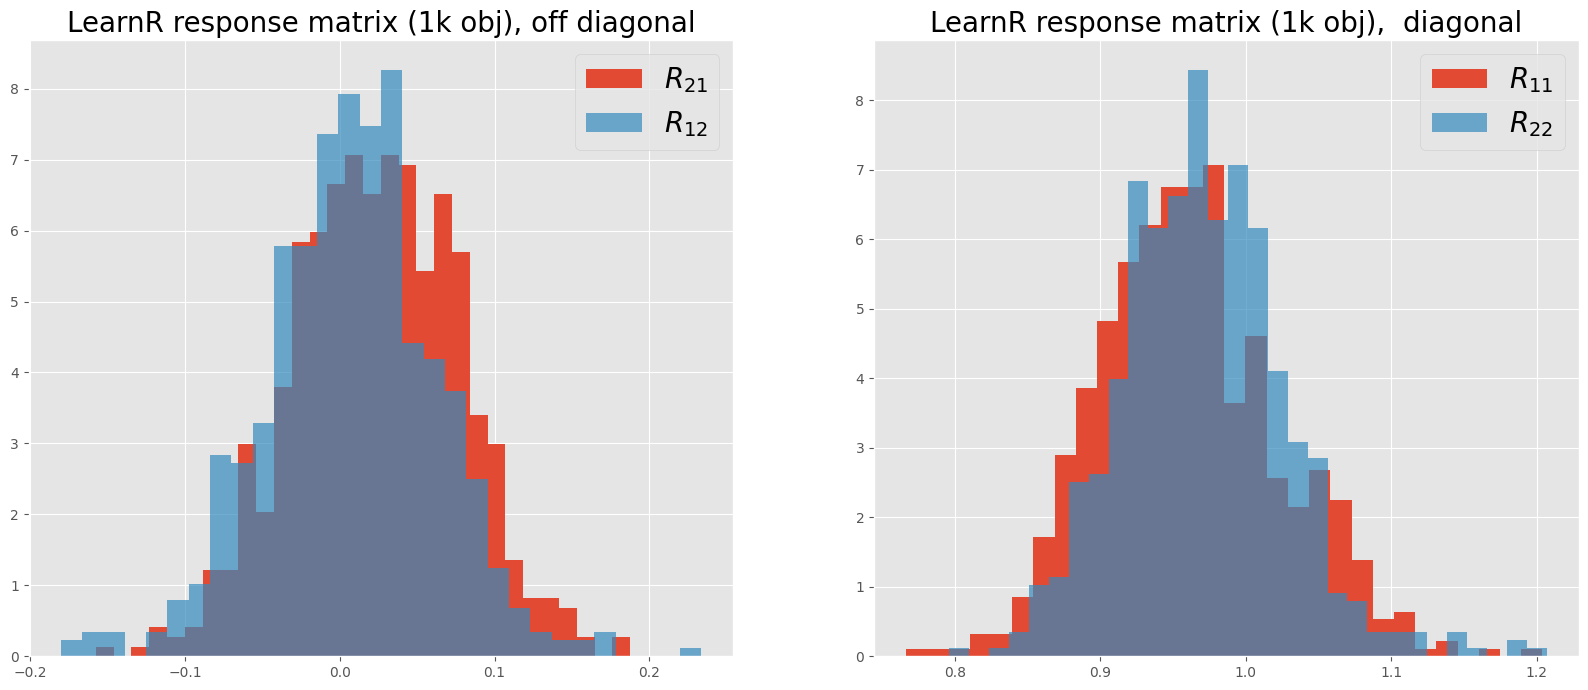

In [23]:
style.use('ggplot')
figure(figsize=(20,8))
subplot(122)
hist(R_auto[:,0,0].numpy()[:],bins=30,density=True,label="$R_{11}$");
hist(R_auto[:,1,1].numpy()[:],bins=30,density=True,label="$R_{22}$",alpha=.7);
title("LearnR response matrix (1k obj),  diagonal",fontsize=20)
legend(fontsize=20)
subplot(121)
hist(R_auto[:,1,0].numpy()[:],bins=30,label="$R_{21}$",density=True);
hist(R_auto[:,0,1].numpy()[:],bins=30,label="$R_{12}$",density=True,alpha=.7);
title("LearnR response matrix (1k obj), off diagonal",fontsize=20)
legend(fontsize=20)
savefig('response_distribution.pdf',bbox_inches='tight')

## New loss (apply shear before noise, PSF, etc.)

In [24]:
import galflow as gf

In [25]:
batch_size=64
data= tfds.load('GalGen/small_stamp_100k')
data = data['train'].cache()
data = data.repeat()
data = data.shuffle(1000)
data = data.batch(batch_size)
data = data.prefetch(tf.data.experimental.AUTOTUNE)
batchit = data.as_numpy_iterator()

In [26]:
import galflow as gf
@tf.function
def generate_real_mcal_image(
  gal_images,
  reconvolution_psf_image,
  g
):
  """ Generate a metacalibrated image given input and target PSFs.
  
  Args: 
    gal_images: tf.Tensor or np.array
      (batch_size, N, N ) image of galaxies
    psf_images: tf.Tensor or np.array
      (batch_size, N, N ) image of psf model
    reconvolution_psf_image: tf.Tensor
      (N, N ) tensor of reconvolution psf model
    g: tf.Tensor or np.array
    [batch_size, 2] input shear
  Returns:
    img: tf.Tensor
      tf tensor containing image of galaxy after deconvolution by psf_deconv, 
      shearing by g, and reconvolution with reconvolution_psf_image.
  
  """
  #cast stuff as float32 tensors
  gal_images = tf.convert_to_tensor(gal_images, dtype=tf.float32)  
  #psf_images = tf.convert_to_tensor(psf_images, dtype=tf.float32) 
  reconvolution_psf_image = tf.convert_to_tensor(reconvolution_psf_image, dtype=tf.float32)  
  g = tf.convert_to_tensor(g, dtype=tf.float32)  
  
  #Get batch info
  batch_size, nx, ny = gal_images.get_shape().as_list()  
      
  #add pads in real space
  padfactor = 3 #total width of image after padding
  fact = (padfactor - 1)//2 #how many image sizes to one direction
  paddings = tf.constant([[0, 0,], [nx*fact, nx*fact], [ny*fact, ny*fact]])
    
  padded_gal_images = tf.pad(gal_images,paddings)
  padded_psf_images = tf.pad(psf_images,paddings)
  padded_reconvolution_psf_image = tf.pad(reconvolution_psf_image,paddings)
    
  #Convert galaxy images to k space
  im_shift = tf.signal.ifftshift(padded_gal_images,axes=[1,2]) # The ifftshift is to remove the phase for centered objects
  im_complex = tf.cast(im_shift, tf.complex64)
  im_fft = tf.signal.fft2d(im_complex)
  imk = tf.signal.fftshift(im_fft, axes=[1,2])#the fftshift is to put the 0 frequency at the center of the k image
  
  #Convert psf images to k space  
  #psf_complex = tf.cast(padded_psf_images, tf.complex64)
  #psf_fft = tf.signal.fft2d(psf_complex)
  #psf_fft_abs = tf.abs(psf_fft)
  #psf_fft_abs_complex = tf.cast(psf_fft_abs,tf.complex64)
  #kpsf = tf.signal.fftshift(psf_fft_abs_complex,axes=[1,2])

  #Convert reconvolution psf image to k space 
  rpsf_complex = tf.cast(padded_reconvolution_psf_image, tf.complex64)
  rpsf_fft =  tf.signal.fft2d(rpsf_complex)
  rpsf_fft_abs = tf.abs(rpsf_fft)
  psf_fft_abs_complex = tf.cast(rpsf_fft_abs,tf.complex64)
  krpsf = tf.signal.fftshift(psf_fft_abs_complex,axes=[1,2])

  # Compute Fourier mask for high frequencies
  # careful, this is not exactly the correct formula for fftfreq
  kx, ky = tf.meshgrid(tf.linspace(-0.5,0.5,padfactor*nx),
                       tf.linspace(-0.5,0.5,padfactor*ny))
  mask = tf.cast(tf.math.sqrt(kx**2 + ky**2) <= 0.5, dtype='complex64')
  mask = tf.expand_dims(mask, axis=0)

  # Deconvolve image from input PSF
  im_deconv = imk * mask #* ( (1./(kpsf+1e-10))*mask)

  # Apply shear
  im_sheared = gf.shear(tf.expand_dims(im_deconv,-1), g[...,0], g[...,1])[...,0]

  # Reconvolve with target PSF
  im_reconv = tf.signal.ifft2d(tf.signal.ifftshift(im_sheared * krpsf * mask))

  # Compute inverse Fourier transform
  img = tf.math.real(tf.signal.fftshift(im_reconv))
  
  # Add noise
  img = img[:,fact*nx:-fact*nx,fact*ny:-fact*ny]
  img += tf.random.normal([nx,ny],0,1e-4)

  return img

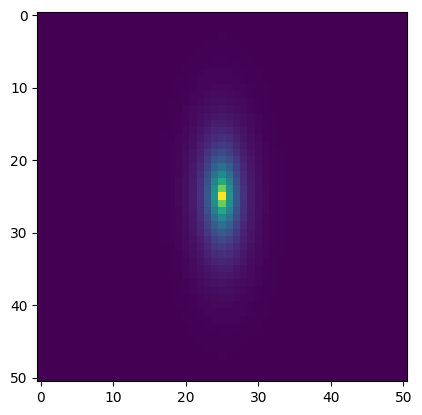

In [27]:
style.use('default')
imshow(onebatch['gal_model'][0])

In [28]:
teste=generate_real_mcal_image(onebatch['gal_model'][0][tf.newaxis],reconv_psf_image,[[0.0,-0.5]])

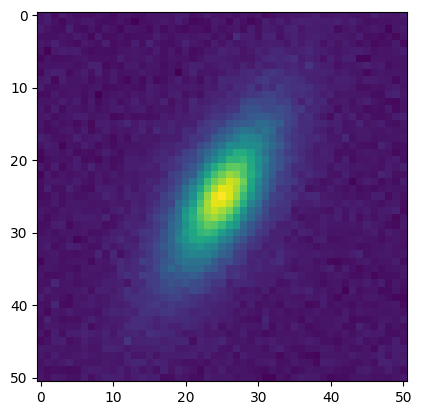

In [29]:
imshow(teste[0])

In [30]:
@tf.function
def get_real_metacal_response_finitediff(gal_image,
                                    reconv_psf_image,
                                    shear,
                                    step,
                                    method):
  """
  Gets shear response as a finite difference operation, 
  instead of automatic differentiation.
  """
  batch_size, _ , _ = gal_image.get_shape().as_list()
  step_batch = tf.constant(step,shape=(batch_size,1),dtype=tf.float32)
  
  step1p = tf.pad(step_batch,[[0,0],[0,1]])
  step1m = tf.pad(-step_batch,[[0,0],[0,1]])
  step2p = tf.pad(step_batch,[[0,0],[1,0]])
  step2m = tf.pad(-step_batch,[[0,0],[1,0]])
    
  img0s = generate_real_mcal_image(
    gal_image,
    reconv_psf_image,
    tf.zeros([batch_size,2])
  ) 
  
  shears1p = shear + step1p
  img1p = generate_real_mcal_image(
    gal_image,
    reconv_psf_image,
    shears1p
  )
  
  shears1m = shear + step1m 
  img1m = generate_real_mcal_image(
    gal_image,
    reconv_psf_image,
    shears1m
  ) 
  
  shears2p = shear + step2p 
  img2p = generate_real_mcal_image(
    gal_image,
    reconv_psf_image,
    shears2p
  )
  
  shears2m = shear + step2m 
  img2m = generate_real_mcal_image(
    gal_image,
    reconv_psf_image,
    shears2m
  ) 
  
  g0s = method(img0s)
  g1p = method(img1p)
  g1m = method(img1m)
  g2p = method(img2p)
  g2m = method(img2m)
  
  R11 = (g1p[:,0]-g1m[:,0])/(2*step)
  R21 = (g1p[:,1]-g1m[:,1])/(2*step) 
  R12 = (g2p[:,0]-g2m[:,0])/(2*step)
  R22 = (g2p[:,1]-g2m[:,1])/(2*step)
 
  #N. B.:The matrix is correct. 
  #The transposition will swap R12 with R21 across a batch correctly.
  R = tf.transpose(tf.convert_to_tensor(
    [[R11,R21],
     [R12,R22]],dtype=tf.float32)
  )
  
  ellip_dict = {
    'noshear':g0s,
    '1p':g1p,
    '1m':g1m,
    '2p':g2p,
    '2m':g2m,    
  } 

  return ellip_dict, R

In [31]:
newmodel = Ribli19(51)

@tf.function
def lossnewmodel(batch,model):
  
  shears = tf.random.uniform((batch_size,2),-.7,.7,dtype=tf.float32)
  #compute response
 
  R = get_real_metacal_response_finitediff(batch['gal_model'],
                                      reconv_psf_image,
                                      shear=shears,
                                      step=0.005,
                                      method=model)[1]
  #R = amc.get_metacal_response(batch['obs_image'],batch['psf_image'],reconv_psf_image,model)[1]
  #R = tf.clip_by_value(R,0,10)
  #lost = #tf.norm(R - tf.eye(2),ord=2)
  lost = tf.reduce_sum((R-tf.eye(2))**2,axis=-1)
  lost = tf.reduce_sum(lost, axis=-1)
  lost = tf.reduce_mean(lost)

  return lost

opt = ko.Adam(lr=1e-5)


@tf.function
def stepnewmodel(batch):
  
  with tf.GradientTape() as tape:
    tape.watch(newmodel.trainable_variables)
       
    lost = lossnewmodel(batch,newmodel)
 
  grads = tape.gradient(lost, newmodel.trainable_variables)
  opt.apply_gradients(zip(grads, newmodel.trainable_variables))
  return lost

/local/home/az264973/.local/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [32]:
lossnewmodel(onebatch,newmodel)

<tf.Tensor: shape=(), dtype=float32, numpy=2.000002>

In [ ]:
lost2 = []
its2 = []
iterations = 10000
for it in range(iterations):
  batch = batchit.next()
  nowlost = stepnewmodel(batch)
  if not it%10:
    print(f"{nowlost: .4f},   {it}  ",end='\r')
    lost2.append(nowlost)
    its2.append(it)  



In [ ]:
it

newmodel.save("RLnewmodel.model")

In [ ]:
style.use('ggplot')
plot(its2[::100],lost2[::100],label='finitediff')
xlabel('iterations')
ylabel('loss')
yscale('log')
legend()
savefig('learningnewmodel4_113446_steps.png',bbox_inches='tight')

In [ ]:
garray_list = []
e_auto_list = []
R_auto_list = []
for n in tqdm.tqdm(range(10)):
  batch = batchit.next()
  garray=batch['label']
  garray_list.append(garray)
  e_auto, R_auto = amc.get_metacal_response(batch['obs_image'],batch['psf_image'],reconv_psf_image,newmodel)
  e_auto_list.append(e_auto)
  R_auto_list.append(R_auto)  

In [ ]:
garray=tf.concat(garray_list,axis=0)
e_auto=tf.concat(e_auto_list,axis=0)
R_auto=tf.concat(R_auto_list,axis=0)

In [ ]:
np.save("garraynewmodel.npy",garray.numpy())
np.save("e_autonewmodel.npy",e_auto.numpy())
np.save("R_autonewmodel.npy",R_auto.numpy())

In [ ]:
calibre_f=mean(tf.linalg.inv(R_auto[:-1]),axis=0) @ tf.reshape(e_auto,[-1,2,1])

In [ ]:
R_auto[:-1]

In [ ]:
figure(figsize=(15,15))
style.use('ggplot')


x1 = garray[:,0]
x2 = garray[:,1]

y1 = e_auto[:,0]
y1corr = calibre_f[:,0,0]

y2 = e_auto[:,1]
y2corr = calibre_f[:,1,0]

#linear fit
poly_g1 = np.polyfit(x1,y1,1)
poly_g2 = np.polyfit(x2,y2,1)


poly_g1corr = np.polyfit(x1,y1corr,1)
poly_g2corr = np.polyfit(x2,y2corr,1)


#correlation coefficient
corr_g1 = pearsonr(x1,y1)
corr_g2 = pearsonr(x2,y2)


corr_g1corr = pearsonr(x1,y1corr)
corr_g2corr = pearsonr(x2,y2corr)


subplot(221)
scatter(x1,y1-mean(y1),alpha=.5,label="uncalibrated")
text(-.6,0.4, "$m_1$ = {:.2e},  $c_1$ = {:.2f}, r = {:.3f}".format(1-poly_g1[0],poly_g1[1],corr_g1[0]),fontsize=15)

title("$e_1$ \"ellipticity\" measurements", fontsize=20)
xlabel("truth",fontsize=20)
ylabel(" rescaled results ($y - \\langle y \\rangle $)",fontsize=20)
legend(fontsize=20,loc=3)


subplot(223)
scatter(x1,y1corr-x1-mean(y1corr),alpha=.5,label="autometacal")
text(-.6,0.2, "$m_1$ = {:.2e},  $c_1$ = {:.2f}, r = {:.3f} (amc)".format(1-poly_g1corr[0],poly_g1corr[1],corr_g1corr[0]),fontsize=15)


xlabel("truth",fontsize=20)
ylabel(" rescaled residuals ($y - x - \\langle y \\rangle $)",fontsize=20)
legend(fontsize=20,loc=3)
xlim(-0.7,0.7)
ylim(-0.7,0.7)

subplot(222)

scatter(x2,y2-mean(y2),alpha=.5,label="uncalibrated")
text(-.6,0.4 , "$m_2$ = {:.2e},  $c_2$ = {:.2f}, r = {:.3f}".format(1-poly_g2[0],poly_g2[1],corr_g2[0]),fontsize=15)

title("$e_2$ \"ellipticity\" measurements", fontsize=20)
xlabel("truth",fontsize=20)
legend(fontsize=20,loc=3)


subplot(224)
scatter(x2,y2corr-x2-mean(y2corr),alpha=.5,label="autometacal")
text(-.6,0.2 , "$m_2$ = {:.2e},  $c_2$ = {:.2f}, r = {:.3f} (amc)".format(1-poly_g2corr[0],poly_g2corr[1],corr_g2corr[0]),fontsize=15)

xlim(-0.7,0.7)
ylim(-0.7,0.7)
xlabel("truth",fontsize=20)
legend(fontsize=20,loc=3)
savefig(f"testeprednewmodel{time.time()}.png",bbox_inches="tight")

In [ ]:
style.use('ggplot')
figure(figsize=(20,8))
subplot(122)
hist(R_auto[:,0,0].numpy()[:],bins=30,density=True,label="$R_{11}$");
hist(R_auto[:,1,1].numpy()[:],bins=30,density=True,label="$R_{22}$",alpha=.7);
title("autometacal response matrix (1k obj),  diagonal",fontsize=20)
legend(fontsize=20)
subplot(121)
hist(R_auto[:,1,0].numpy()[:],bins=30,label="$R_{21}$",density=True);
hist(R_auto[:,0,1].numpy()[:],bins=30,label="$R_{12}$",density=True,alpha=.7);
title("autometacal response matrix (1k obj), off diagonal",fontsize=20)
legend(fontsize=20)
savefig('response_distribution_newmodel.pdf',bbox_inches='tight')

In [ ]:
banana();

## Testing the trained model in the wild:

In [ ]:
from scipy.stats import truncnorm
g_list = []
i=0
gmax=.7
gscale = .2
gloc=0
Ngal=200
while i<Ngal :
  a, b = (-gmax - gloc) / gscale, (gmax - gloc) / gscale
  g1=g2=1
  #select ellipticities, ensure g<=1
  while g1**2+g2**2>1:
    g1 = truncnorm.rvs(a, b, loc=gloc, scale=gscale)
    g2 = truncnorm.rvs(a, b, loc=gloc, scale=gscale)
    i+=1
  g_list.append([g1,g2])
garrayt = np.array(g_list)


In [ ]:
def make_data(N=1,
  snr = 80,
  scale = 0.263,
  stamp_size = 51,
  psf_fwhm = 0.9,
  gal_hlr = 0.7,
  gal_g1 = [0],
  gal_g2 = [0]):
  
  gal_list = []
  psf_list = []
  
  for n in range(N):
    psf = galsim.Kolmogorov(fwhm=psf_fwhm).withFlux(1.0)

    obj0 = galsim.Exponential(half_light_radius=gal_hlr,flux=1e5).shear(g1=gal_g1[n],g2=gal_g2[n])
    obj = galsim.Convolve(psf, obj0)

    psf_image = psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale)
    gal_image = obj.drawImage(nx=stamp_size, ny=stamp_size, scale=scale)
    noise = galsim.GaussianNoise()
    gal_image.addNoiseSNR(noise,snr)
    gal_image = tf.convert_to_tensor(gal_image.array)
    psf_image = tf.convert_to_tensor(psf_image.array)
    gal_list.append(gal_image)
    psf_list.append(psf_image)
    del gal_image
    del psf_image
  gal_image_stack = tf.stack(gal_list)
  psf_image_stack = tf.stack(psf_list)
  return gal_image_stack, psf_image_stack

In [ ]:
snr= 1200
scale = 0.2
stamp_size = 51
psf_fwhm = 0.9
gal_hlr = 0.7

gal_images, psf_images = make_data(N=Ngal,
                                  snr = snr,
                                  scale = scale,
                                  stamp_size = stamp_size,
                                  psf_fwhm = psf_fwhm,
                                  gal_hlr = gal_hlr,
                                  gal_g1=garrayt.T[0],gal_g2=garrayt.T[1])

In [ ]:
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(gal_images[i])

In [ ]:
e_auto, R_auto = amc.get_metacal_response(gal_images,psf_images,reconv_psf_image,model)

In [ ]:
calibre_f=(tf.linalg.inv(R_auto[:])) @ tf.reshape(e_auto,[-1,2,1])

In [ ]:
figure(figsize=(20,10))

subplot(121)

x1 = garrayt[:,0]
x2 = garrayt[:,1]

y1 = e_auto[:,0]
y1corr = calibre_f[:,0,0]

y2 = e_auto[:,1]
y2corr = calibre_f[:,1,0]

#linear fit
poly_g1 = np.polyfit(x1,y1,1)
poly_g2 = np.polyfit(x2,y2,1)


poly_g1corr = np.polyfit(x1,y1corr,1)
poly_g2corr = np.polyfit(x2,y2corr,1)


#correlation coefficient
corr_g1 = pearsonr(x1,y1)
corr_g2 = pearsonr(x2,y2)


corr_g1corr = pearsonr(x1,y1corr)
corr_g2corr = pearsonr(x2,y2corr)


scatter(x1,y1-x1-mean(y1),alpha=.7,label="uncalibrated")
scatter(x1,y1corr-x1-mean(y1corr),alpha=.7,label="autometacal")
text(-.6,0.4, "$m_1$ = {:.2e},  $c_1$ = {:.2e}, r = {:.2e} (uncorrected)".format(1-poly_g1[0],poly_g1[1],corr_g1[0]),fontsize=15)
text(-.6,0.2, "$m_1$ = {:.2e},  $c_1$ = {:.2e}, r = {:.2e} (amc)".format(1-poly_g1corr[0],poly_g1corr[1],corr_g1corr[0]),fontsize=15)



title("$e_1$ ellipticity measurements", fontsize=20)
xlabel("truth",fontsize=20)
ylabel(" rescaled residuals ($y-x-\\langle y \\rangle $)",fontsize=20)
legend(fontsize=20,loc=3)
xlim(-0.7,0.7)
ylim(-0.7,0.7)

subplot(122)

scatter(x2,y2-x2-mean(y2),alpha=.7,label="uncalibrated")
scatter(x2,y2corr-x2-mean(y2corr),alpha=.7,label="autometacal")
text(-.6,0.4 , "$m_2$ = {:.2e},  $c_2$ = {:.2e}, r = {:.2e} (uncorrected) ".format(1-poly_g2[0],poly_g2[1],corr_g2[0]),fontsize=15)
text(-.6,0.2 , "$m_2$ = {:.2e},  $c_2$ = {:.2e}, r = {:.2e} (amc)".format(1-poly_g2corr[0],poly_g2corr[1],corr_g2corr[0]),fontsize=15)

title("$e_2$ ellipticity measurements", fontsize=20)
xlabel("truth",fontsize=20)

legend(fontsize=20,loc=3)
xlim(-0.7,0.7)
ylim(-0.7,0.7)
savefig(f"linearity_exotic_test.pdf",bbox_inches="tight")

In [ ]:
style.use('ggplot')
figure(figsize=(20,8))
subplot(122)
hist(R_auto[:,0,0].numpy()[:],bins=30,density=True,label="$R_{11}$");
hist(R_auto[:,1,1].numpy()[:],bins=30,density=True,label="$R_{22}$",alpha=.7);
title("autometacal response matrix (1k obj),  diagonal",fontsize=20)
legend(fontsize=20)
subplot(121)
hist(R_auto[:,1,0].numpy()[:],bins=30,label="$R_{21}$",density=True);
hist(R_auto[:,0,1].numpy()[:],bins=30,label="$R_{12}$",density=True,alpha=.7);
title("autometacal response matrix (1k obj), off diagonal",fontsize=20)
legend(fontsize=20)
savefig('response_distribution_exotic_data.pdf',bbox_inches='tight')